# Notebook Structure

1. Data Cleaning
        1.1 Members data
        1.2 Packs data
        1.3 Merged data 
        1.4 *Dealing with nulls!!!
        
2. Train-Test-Validation sets -- skipped for now

3. Feature Engineering

4. Feature Importance
        4.1 OLS Model on complete data
        4.2 LR Model on complete data
        4.3 DT Model on complete data
        4.4 RF Model on complete data
        4.5 Table representing MAE
        4.6 Table representing feature importance

5. Final Models per person
        5.1 LR model per person
        5.2 DT model per person
        5.3 RF model per person

# 1. Data Cleaning

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [5]:
path = '/Users/aishwaryasingh/PuzzleSchedulingProject/puzzle-scheduling/data/'

# Loading cleaned data

In [8]:
df_features_combined = pd.read_csv(path+'df_features_combined.csv')

In [9]:
df_features_combined.shape

(19387, 16)

### 1.1 Members Data

In [4]:
member_holdtime_df = pd.read_csv(path+'member_hold_times_and_packs_Feb16_2023.tsv', 
                                 sep='\t', header=None)
member_holdtime_df.columns = ['memberID', 'holdtime', 'puzzlepack']
member_holdtime_df.shape

(19733, 3)

In [5]:
member_holdtime_df.isnull().sum()

memberID      0
holdtime      0
puzzlepack    0
dtype: int64

In [6]:
# removing outliers
member_holdtime_df = member_holdtime_df[(member_holdtime_df['holdtime'] >= 0.1) & 
                                        (member_holdtime_df['holdtime'] <= 150)]

### 1.2 Packs Data

In [7]:
packs_df = pd.read_csv(path + 'packs_Feb16_2023.tsv', sep='\t', header=None)
packs_df.columns = ['pack_name', 'brand', 'piece_count', 'difficulty_rating']
packs_df.shape

(920, 4)

In [8]:
# making two coulmns for piece count
packs_df['piece_count_1'] = packs_df['piece_count'].str.split(',', expand=True)[0]
packs_df['piece_count_2'] = packs_df['piece_count'].str.split(',', expand=True)[1]
# making two columns for difficulty
packs_df['difficulty_rating_1'] = packs_df['difficulty_rating'].str.split(',', expand=True)[0]
packs_df['difficulty_rating_2'] = packs_df['difficulty_rating'].str.split(',', expand=True)[1]

In [9]:
# splitting brand name
packs_df['brand_2'] = packs_df['brand'].str.split(',', expand=True)[1]
packs_df['brand_1'] = packs_df['brand'].str.split(',', expand=True)[0]

In [10]:
# adding number of puzzles feature
packs_df['num_puzzles'] = packs_df['pack_name'].map(lambda n: 1 if (n[-1] == ' ') else 2, na_action='ignore')

In [11]:
# fixing datatype
packs_df = packs_df.astype({'piece_count_1': 'int64', 'piece_count_2': 'int64'}, errors='ignore')

In [12]:
# dropping the initial variables
packs_df.drop(['brand', 'piece_count', 'difficulty_rating'], axis=1, inplace=True)

In [13]:
packs_df.isnull().sum()

pack_name                0
piece_count_1            8
piece_count_2          181
difficulty_rating_1      4
difficulty_rating_2      4
brand_2                775
brand_1                 25
num_puzzles              0
dtype: int64

In [15]:
# making the brand_2 same as brand_1
# ------ must be done only for puzzle = 2, right?
packs_df.loc[(packs_df['brand_2'].isna()), 'brand_2'] = packs_df['brand_1']

In [16]:
packs_df[['brand_1', 'brand_2']] = packs_df[['brand_1', 'brand_2']].fillna('unknown')

In [17]:
# Some 1 puzzle packs have a second number for pieces, this seems to be legit, updating to be 2 puzzle packs
packs_df.loc[((packs_df.num_puzzles == 1) & (packs_df.piece_count_2.notna())), 'num_puzzles'] = 2

In [18]:
packs_df.piece_count_1 = packs_df.piece_count_1.astype('float').astype('Int64')
packs_df.piece_count_2 = packs_df.piece_count_2.astype('float').astype('Int64')

avg_pc1 = packs_df['piece_count_1'].median()
avg_pc2 = packs_df['piece_count_2'].median()

In [19]:
# puzzles which have no value for piece_1 is replaced with avg values
packs_df['piece_count_1'].fillna(avg_pc1, inplace=True)

In [20]:
# if 2 puzzles and second piececount is not available, replace with average
packs_df.loc[((packs_df['piece_count_2'].isna() ) &(packs_df['num_puzzles'] ==2)), 'piece_count_2'] = int(avg_pc2)

In [21]:
# puzzles with no second piece_count, make second piece count 0 
# (because num_puzzle = 2 was dealt with earlier)
packs_df.loc[(packs_df['piece_count_2'].isna()) & (packs_df['num_puzzles'] ==1), 'piece_count_2'] = int(0)

In [22]:
packs_df.isnull().sum()

pack_name              0
piece_count_1          0
piece_count_2          0
difficulty_rating_1    4
difficulty_rating_2    4
brand_2                0
brand_1                0
num_puzzles            0
dtype: int64

In [23]:
packs_df['difficulty_rating_1'].fillna('Average', inplace=True)
packs_df['difficulty_rating_2'].fillna('Average', inplace=True)

### 1.3 Merged data

In [24]:
df = member_holdtime_df.merge(packs_df, left_on='puzzlepack', right_on='pack_name', how='left')
df.head(2)

,memberID,holdtime,puzzlepack,pack_name,piece_count_1,piece_count_2,difficulty_rating_1,difficulty_rating_2,brand_2,brand_1,num_puzzles
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,A-Easy,Average,Artifact,Artifact,2.0
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,220,A-Easy,Hard,DaVici,DaVici,2.0


In [25]:
df.shape, member_holdtime_df.shape

((19387, 11), (19387, 3))

In [26]:
member_holdtime_df.puzzlepack.nunique(), packs_df.pack_name.nunique(), 

(968, 920)

In [27]:
df.isnull().sum()
# about 5% of the data is missing

memberID                  0
holdtime                  0
puzzlepack                0
pack_name              1085
piece_count_1          1085
piece_count_2          1085
difficulty_rating_1    1085
difficulty_rating_2    1085
brand_2                1085
brand_1                1085
num_puzzles            1085
dtype: int64

<div class="alert alert-block alert-info">
<b>Tip:</b> # Ideally we should have information about all the packs. Since we do not have this information and it is recommended that we do not drop these rows, we will impute these with the average values.
</div>

### 1.4 Dealing with Nulls!
**Methodology**

* num_puzzles --> Count number of times 'Puzzle' appears in puzzlepack
* brand_1, brand_2 --> Take word before 'Puzzle' as brand name
* difficulty_rating --> Take average at brand level from known data
* piece_count --> Take average at brand level from known data

In [28]:
missing_pack_data = df.loc[df['pack_name'].isna()][['puzzlepack', 'piece_count_1', 'piece_count_2',
                               'difficulty_rating_1', 'difficulty_rating_2', 'brand_1', 
                                'brand_2', 'num_puzzles']]
missing_pack_data.reset_index(drop=True, inplace=True)

In [29]:
# getting number of puzzles
missing_pack_data['num_puzzles'] = missing_pack_data['puzzlepack'].apply(lambda x: (x.count('Puzzles')))

In [30]:
# packs can have only 1 or two puzzles
for i in range(0, len(missing_pack_data)):
    if missing_pack_data['num_puzzles'][i] < 1:
        missing_pack_data['num_puzzles'][i] = 1
    elif missing_pack_data['num_puzzles'][i] > 2:
        missing_pack_data['num_puzzles'][i] = 2
    else: 
        pass

In [31]:
## to limit the number of brand names we will only use the brands that we know
known_brands = list(set(packs_df['brand_1'].unique()).union(set(packs_df['brand_2'].unique())))

In [32]:
# getting brand_1
for i in range(0,len(missing_pack_data)):
    words = missing_pack_data['puzzlepack'][i].split()[0:2] 
    
    if 'Puzzles' in words[1:]: #if its the second or third word
        if words[words.index('Puzzles')-1] in(known_brands):
            missing_pack_data['brand_1'][i] = words[words.index('Puzzles')-1]
        else:
            missing_pack_data['brand_1'][i] = 'unknown'

In [33]:
# getting brand_2
for i in range(0,len(missing_pack_data)):
    words = missing_pack_data['puzzlepack'][i].split()[2:]
    if 'Puzzles' in words[1:]: #if its the 4th word onwards
        if words[words.index('Puzzles')-1] in(known_brands):
            missing_pack_data['brand_2'][i] = words[words.index('Puzzles')-1]
        else:
            missing_pack_data['brand_2'][i] = 'unknown'

In [34]:
missing_pack_data[['num_puzzles', 'brand_1', 'brand_2']].isnull().sum()

num_puzzles      0
brand_1        139
brand_2        333
dtype: int64

In [35]:
# if anything still missing in num_puzzles, brands
missing_pack_data['num_puzzles'].fillna(1, inplace=True)
missing_pack_data['brand_1'].fillna('unknown', inplace=True)
missing_pack_data['brand_2'].fillna('unknown', inplace=True)

In [36]:
# brand level average piece count values -- KNOWN data
groupby_brand_pieces_1 = packs_df.groupby("brand_1")["piece_count_1"].mean()
groupby_brand_pieces_2 = packs_df.groupby("brand_2")["piece_count_2"].mean()

In [37]:
# getting piece_count_1
for i in range(0, len(missing_pack_data)):
    try:
        missing_pack_data['piece_count_1'][i] = int(groupby_brand_pieces_1[missing_pack_data['brand_1'][i]])
        # getting piece_count_2 if needed
        if missing_pack_data['num_puzzles'][i] == 1:
            missing_pack_data['piece_count_2'][i] = 0
        else:
            missing_pack_data['piece_count_2'][i] = int(groupby_brand_pieces_2[missing_pack_data['brand_2'][i]])
    except Exception as e:
        pass
#         print(e)

In [38]:
# brand level most common difficulty values -- KNOWN data
groupby_brand_diff_1 = packs_df.groupby("brand_1")["difficulty_rating_1"].agg(pd.Series.mode)
groupby_brand_diff_2 = packs_df.groupby("brand_2")["difficulty_rating_2"].agg(pd.Series.mode)

In [39]:
# getting difficulty_rating_1
for i in range(0, len(missing_pack_data)):
    try:
        missing_pack_data['difficulty_rating_1'][i] = groupby_brand_diff_1[missing_pack_data['brand_1'][i]]
        # getting difficulty_rating_2 if needed
        if missing_pack_data['num_puzzles'][i] == 1:
            missing_pack_data['difficulty_rating_2'][i] = 'Average'
        else:
            missing_pack_data['difficulty_rating_2'][i] = (groupby_brand_diff_2[missing_pack_data['brand_2'][i]])
    except Exception as e:
        pass

In [40]:
missing_pack_data.isnull().sum()

puzzlepack             0
piece_count_1          0
piece_count_2          0
difficulty_rating_1    0
difficulty_rating_2    0
brand_1                0
brand_2                0
num_puzzles            0
dtype: int64

### Making a final packs data

In [41]:
# setting order same as missing pack to concat easily
packs_df = packs_df[['pack_name', 'piece_count_1', 'piece_count_2', 'difficulty_rating_1', 
                             'difficulty_rating_2', 'brand_1', 'brand_2', 'num_puzzles']]

In [42]:
# setting same column names to concat easily
missing_pack_data = missing_pack_data.rename(columns = {'puzzlepack':'pack_name'})

In [43]:
packs_df.shape, missing_pack_data.shape

((920, 8), (1085, 8))

In [44]:
packs_updated = pd.concat([packs_df, missing_pack_data])
packs_updated.reset_index(inplace=True, drop = True)
packs_updated.shape

(2005, 8)

In [45]:
df_cleaned = member_holdtime_df.merge(packs_updated, left_on='puzzlepack', right_on='pack_name', how='left')
df_cleaned.head(2)

,memberID,holdtime,puzzlepack,pack_name,piece_count_1,piece_count_2,difficulty_rating_1,difficulty_rating_2,brand_1,brand_2,num_puzzles
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,A-Easy,Average,Artifact,Artifact,2
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,220,A-Easy,Hard,DaVici,DaVici,2


In [46]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [47]:
difficulty_mapping = {'A-Easy': 1, 'Average': 2, 'Hard': 3, 'Really-Hard': 4}

df_cleaned['difficulty_rating_1'] = df_cleaned['difficulty_rating_1'].map(lambda x: difficulty_mapping[x], na_action='ignore')
df_cleaned['difficulty_rating_2'] = df_cleaned['difficulty_rating_2'].map(lambda x: difficulty_mapping[x], na_action='ignore')

In [48]:
df_cleaned.shape, df.shape, member_holdtime_df.shape

((19387, 11), (19387, 11), (19387, 3))

In [49]:
df_cleaned.isnull().sum()

memberID               0
holdtime               0
puzzlepack             0
pack_name              0
piece_count_1          0
piece_count_2          0
difficulty_rating_1    0
difficulty_rating_2    0
brand_1                0
brand_2                0
num_puzzles            0
dtype: int64

# 3. Feature Engineering

### First feature is number of pieces for each difficulty d1, d2, d3, d4

In [50]:
# taking code from jon's branch
pieces_by_difficulty = []

for i, row in df_cleaned.iterrows():
    out = {
        'name': row['pack_name'],
        'pieces_d1': 0,
        'pieces_d2': 0,
        'pieces_d3': 0,
        'pieces_d4': 0,
        'num_puzzles': row['num_puzzles']
    }
    
    if not math.isnan(row['piece_count_1']):
        out[f'pieces_d{str(int(row["difficulty_rating_1"]))}'] += row['piece_count_1']
    
    if(row['num_puzzles'] == 2 and math.isnan(row['piece_count_1']) == False):
        out[f'pieces_d{str(int(row["difficulty_rating_2"]))}'] += row['piece_count_2']
        
    pieces_by_difficulty.append(out)

In [51]:
pieces_df = pd.DataFrame(pieces_by_difficulty)
pieces_df.head()

,name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles
0,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
1,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,0,220,0,2
2,DaVici Puzzles Flying Frigate DaVici Puzzles H...,496,0,0,0,2
3,Liberty Puzzles Haeckel Hummingbirds Nautilus ...,0,707,0,0,2
4,DaVici Puzzles Diana Zimens City Of Cats,0,700,0,0,1


### Second Feature is counting total number of pieces at pack level

In [52]:
# making things at pack level
df_cleaned['piece_count_pack'] = 0
df_cleaned['difficulty_rating_pack'] = 0
for i in range(0, len(df_cleaned)):
    if df_cleaned['num_puzzles'][i] == 1:
        df_cleaned['piece_count_pack'][i] = df_cleaned['piece_count_1'][i]
        df_cleaned['difficulty_rating_pack'][i] = df_cleaned['difficulty_rating_1'][i]
    else:
        df_cleaned['piece_count_pack'][i] = df_cleaned['piece_count_1'][i] + df_cleaned['piece_count_2'][i]
        df_cleaned['difficulty_rating_pack'][i] = (df_cleaned['difficulty_rating_1'][i] + df_cleaned['difficulty_rating_2'][i])//2

### Third feautre is combining difficulty and piece count into a single column values

In [53]:
# taking code from madalyn's branch
pieces_df['w_pieces_diff'] = pieces_df['pieces_d1'] + pieces_df['pieces_d2']*2 + pieces_df['pieces_d3']*3 + pieces_df['pieces_d4']*4

# use box cox method to transform weighted pieces by difficulty
from sklearn.preprocessing import power_transform 
pieces_df['w_pieces_diff_transformed'] = power_transform(pieces_df[['w_pieces_diff']], method='box-cox')


In [54]:
# creat list of bin names and label names
# I just picked an arbitrary number of 20 bins, to group the piece difficulty by, this can be improved on
step = (pieces_df['w_pieces_diff_transformed'].max()-pieces_df['w_pieces_diff_transformed'].min())/20
bins = np.arange(pieces_df['w_pieces_diff_transformed'].min(), pieces_df['w_pieces_diff_transformed'].max()+step, step)
labels = ['bin' + s for s in map(str, list(range(len(bins)-1)))]

# label each puzzle by binned piece & difficulty
pieces_df['bin_label'] = pd.cut(x = pieces_df['w_pieces_diff_transformed'], bins = bins, labels = labels, include_lowest = True)
pieces_df.head()

,name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,w_pieces_diff,w_pieces_diff_transformed,bin_label
0,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2,1552,0.476563,bin9
1,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,0,220,0,2,855,-0.550938,bin6
2,DaVici Puzzles Flying Frigate DaVici Puzzles H...,496,0,0,0,2,496,-1.335665,bin3
3,Liberty Puzzles Haeckel Hummingbirds Nautilus ...,0,707,0,0,2,1414,0.303165,bin9
4,DaVici Puzzles Diana Zimens City Of Cats,0,700,0,0,1,1400,0.284934,bin8


In [55]:
df_cleaned.shape, pieces_df.shape

((19387, 13), (19387, 9))

In [56]:
df_cleaned.columns

Index(['memberID', 'holdtime', 'puzzlepack', 'pack_name', 'piece_count_1',
       'piece_count_2', 'difficulty_rating_1', 'difficulty_rating_2',
       'brand_1', 'brand_2', 'num_puzzles', 'piece_count_pack',
       'difficulty_rating_pack'],
      dtype='object')

In [113]:
concat_df1 = df_cleaned[['pack_name', 'holdtime', 'piece_count_1', 'piece_count_2', 'difficulty_rating_1', 
                         'difficulty_rating_2',  'brand_1','piece_count_pack', 'difficulty_rating_pack',
                         'brand_2', 'num_puzzles']]
concat_df2 = pieces_df[['pieces_d1', 'pieces_d2', 'pieces_d3', 'pieces_d4', 'w_pieces_diff_transformed']]

In [114]:
df_features_combined = pd.concat([concat_df1, concat_df2], axis=1)

# 4. Feature Importances

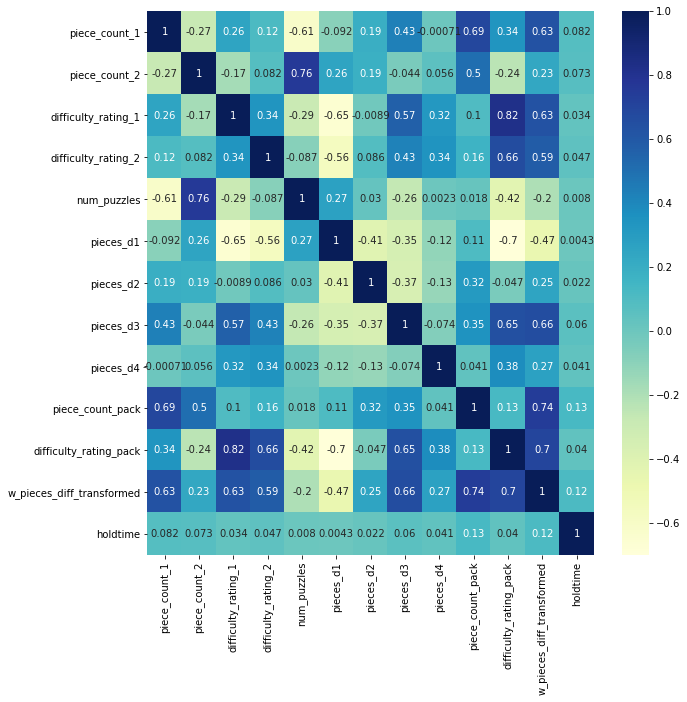

In [10]:
# plotting correlation heatmap
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(df_features_combined.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [11]:
# random split into train and validation
train, test = train_test_split(df_features_combined, test_size = 0.25, random_state=1)

In [12]:
x_train = train.drop(['holdtime', 'pack_name'], axis=1)
y_train = train['holdtime']

In [13]:
x_test = test.drop(['holdtime', 'pack_name'], axis = 1)
y_test = test['holdtime']

### 4.1 Benchmark Model

In [14]:
# First just try average hold time by member
train_holdtime_mean = y_train.mean()

pred1 = np.empty(len(y_test)) 
pred1.fill(train_holdtime_mean)

mean_absolute_error(y_test, pred1)

12.62234436965736

### 4.2 Linear Regression

In [15]:
# dummy variable - hopefully x_test doesnt bring any surprises
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_train.shape, x_test.shape

((14540, 32), (4847, 32))

In [16]:
# simple linear regression
model_lr = LinearRegression(normalize=True)
model_lr.fit(x_train, y_train)  #fit the model
pred2 = model_lr.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred2) #calculate mae

12.399774854915188

In [17]:
coefficients = pd.concat([pd.DataFrame(x_train.columns,columns=['columns']),
                          pd.DataFrame(np.transpose(model_lr.coef_),columns=['coefficients'])], axis = 1)
coefficients.sort_values(by = 'coefficients').head(15)

,columns,coefficients
29,brand_2_Stave,-3.803798e+14
27,brand_2_Other-Hand-cut,-3.803798e+14
22,brand_2_Artifact,-3.803798e+14
30,brand_2_Wentworth,-3.803798e+14
31,brand_2_unknown,-3.803798e+14
28,brand_2_Other-Laser-cut,-3.803798e+14
24,brand_2_Ecru,-3.803798e+14
25,brand_2_Liberty,-3.803798e+14
23,brand_2_DaVici,-3.803798e+14
26,brand_2_Nautilus,-3.803798e+14


Cannot say anything about the coefficients right now. Need p-values. Building OLS model to get that.

### 4.3 OLS model

In [18]:
from sklearn import datasets, linear_model
import statsmodels.api as sma

In [19]:
X = x_train
y = y_train
X2  = sma.add_constant(X)

In [20]:
est = sma.OLS(y, X2.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               holdtime   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     12.47
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           2.03e-56
Time:                        16:51:30   Log-Likelihood:                -63087.
No. Observations:               14540   AIC:                         1.262e+05
Df Residuals:                   14511   BIC:                         1.265e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

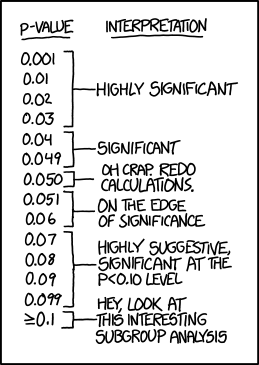

### 4.4 Decision Tree

In [21]:
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'max_depth': [3, 5, 7, 9, 11, 15, 17]}
    # decision tree model
    dtree_model = DecisionTreeRegressor()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [22]:
dtree_grid_search(X = x_train, y = y_train, nfolds = 5)

{'max_depth': 3}

In [23]:
model_dt = DecisionTreeRegressor(max_depth = 3,random_state=0)
model_dt.fit(x_train, y_train)  #fit the model
pred3 = model_dt.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred3) #calculate mae

12.447865314968272

In [24]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, model_dt.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [25]:
importances.sort_values(by = 'Gini-importance', ascending=False).head(15)

,Gini-importance
piece_count_pack,0.607699
w_pieces_diff_transformed,0.258662
brand_1_Artifact,0.088650
pieces_d3,0.044989
brand_2_Ecru,0.000000
brand_1_Wentworth,0.000000
brand_1_unknown,0.000000
brand_2_Artifact,0.000000
brand_2_DaVici,0.000000
piece_count_1,0.000000


### 4.4 Random Forest

In [26]:
def rf_grid_search(X,y,nfolds):
    param_grid = {'max_depth': [3, 5, 7, 9], 'n_estimators': [50, 70, 100, 150, 200]}
    rf_model = RandomForestRegressor()
    rf_gscv = GridSearchCV(rf_model, param_grid, cv=nfolds)
    rf_gscv.fit(X, y)
    return rf_gscv.best_params_

In [27]:
rf_grid_search(X = x_train, y = y_train, nfolds = 5)

{'max_depth': 3, 'n_estimators': 100}

In [28]:
model_rf = RandomForestRegressor(max_depth = 3,n_estimators=200, random_state=0)
model_rf.fit(x_train, y_train)  #fit the model
pred4 = model_rf.predict(x_test) #make prediction on test set
mean_absolute_error(y_test, pred4) #calculate mae

12.436204414656602

In [29]:
feats_rf = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, model_rf.feature_importances_):
    feats_rf[feature] = importance #add the name/value pair 

importances_rf = pd.DataFrame.from_dict(feats_rf, orient='index').rename(columns={0: 'feature_importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [30]:
importances_rf.sort_values(by='feature_importance', ascending=False).head(15)

,feature_importance
piece_count_pack,0.575958
w_pieces_diff_transformed,0.213131
brand_1_Artifact,0.046877
piece_count_1,0.043080
pieces_d4,0.033324
piece_count_2,0.016813
pieces_d3,0.015915
pieces_d1,0.015663
pieces_d2,0.011825
difficulty_rating_1,0.007307


### 